In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
%matplotlib inline

In [2]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


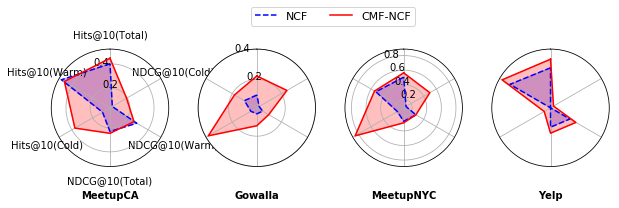

In [10]:
def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Hits@10(Total)', 'Hits@10(Warm)', 'Hits@10(Cold)', 'NDCG@10(Total)', 'NDCG@10(Warm)', 'NDCG@10(Cold)'],
        ('MeetupCA', [
            [0.400, 0.500, 0.106, 0.231, 0.290, 0.056], #NCF
            [0.446, 0.472, 0.371, 0.246, 0.264, 0.193]]),
        ('Gowalla', [
            [0.097, 0.107, 0.058, 0.052, 0.057, 0.030], 
            [0.223, 0.183, 0.383, 0.131, 0.103, 0.242]]),
        ('MeetupNYC', [
            [0.504, 0.524, 0.185, 0.269, 0.278, 0.121], 
            [0.563, 0.545, 0.852, 0.290, 0.277, 0.498]]),
        ('Yelp', [
            [0.093, 0.109, 0.000, 0.045, 0.052, 0.000], 
            [0.113, 0.130, 0.017, 0.059, 0.068, 0.008]]),
    ]
    return data



N = 6
theta = radar_factory(N, frame='circle')

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
linestyles = ['--', 'solid', '--', '-', '-']
# Plot the four cases from the example data on separate axes
'''
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(data[0][0], weight='bold', size='medium', position=(0.5, -0.3),
             horizontalalignment='center', verticalalignment='center')
for d, color, linestyle in zip(data[0][1], colors, linestyles):
    ax.plot(theta, d, color=color, linestyle=linestyle)
    ax.fill(theta, d, facecolor=color, alpha=0.25)
ax.set_varlabels(spoke_labels)
'''
i= 0
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, -0.3),
                 horizontalalignment='center', verticalalignment='center')
    for d, color, linestyle in zip(case_data, colors, linestyles):
        ax.plot(theta, d, color=color, linestyle=linestyle)
        ax.fill(theta, d, color=color, alpha=0.25)
    if i == 0:
        ax.set_varlabels(spoke_labels)
        i+=1
    else:
        ax.set_varlabels(['','','','','',''])

# add legend relative to top-left plot
labels = ('NCF', 'CMF-NCF')
legend = axs[0].legend(labels, loc=(1.7, 1.2),
                          labelspacing=0.1, fontsize='11', ncol=2)

#fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#         horizontalalignment='center', color='black', weight='bold',
#         size='large')
plt.savefig('figures/radar_NCF.pdf', bbox_inches="tight")
plt.show()

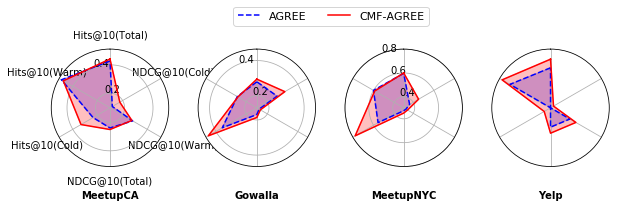

In [15]:
def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Hits@10(Total)', 'Hits@10(Warm)', 'Hits@10(Cold)', 'NDCG@10(Total)', 'NDCG@10(Warm)', 'NDCG@10(Cold)'],
        ('MeetupCA', [
            [0.427, 0.492, 0.235, 0.239, 0.281, 0.116], #AGREE
            [0.441, 0.477, 0.333, 0.250, 0.275, 0.177]]),
        ('Gowalla', [
            [0.279, 0.259, 0.358, 0.169, 0.146, 0.264], 
            [0.294, 0.255, 0.450, 0.186, 0.154, 0.315]]),
        ('MeetupNYC', [
            [0.597, 0.600, 0.556, 0.332, 0.330, 0.365], 
            [0.600, 0.589, 0.778, 0.352, 0.345, 0.452]]),
        ('Yelp', [
            [0.093, 0.109, 0.000, 0.045, 0.052, 0.000], 
            [0.113, 0.130, 0.017, 0.059, 0.068, 0.008]]),
    ]
    return data



N = 6
theta = radar_factory(N, frame='circle')

data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
linestyles = ['--', 'solid', '--', '-', '-']
# Plot the four cases from the example data on separate axes
'''
ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
ax.set_title(data[0][0], weight='bold', size='medium', position=(0.5, -0.3),
             horizontalalignment='center', verticalalignment='center')
for d, color, linestyle in zip(data[0][1], colors, linestyles):
    ax.plot(theta, d, color=color, linestyle=linestyle)
    ax.fill(theta, d, facecolor=color, alpha=0.25)
ax.set_varlabels(spoke_labels)
'''
i= 0
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, -0.3),
                 horizontalalignment='center', verticalalignment='center')
    for d, color, linestyle in zip(case_data, colors, linestyles):
        ax.plot(theta, d, color=color, linestyle=linestyle)
        ax.fill(theta, d, color=color, alpha=0.25)
    if i == 0:
        ax.set_varlabels(spoke_labels)
        i+=1
    else:
        ax.set_varlabels(['','','','','',''])

# add legend relative to top-left plot
labels = ('AGREE', 'CMF-AGREE')
legend = axs[0].legend(labels, loc=(1.55, 1.2),
                          labelspacing=0.1, fontsize='11', ncol=2)

#fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
#         horizontalalignment='center', color='black', weight='bold',
#         size='large')
plt.savefig('figures/radar_AGREE.pdf', bbox_inches="tight")
plt.show()